In [170]:
from __future__ import print_function
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.python.keras.layers import Conv2D, UpSampling2D, BatchNormalization
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [97]:
with open('data.pkl', 'rb') as f:
    x_train = pickle.load(f)
x_train = x_train.astype('float32')
#x_train /= 255

In [195]:
m = 4; n = 1; k = 0;
X_train = np.zeros((x_train.shape[0]-k-m, x_train.shape[1], x_train.shape[2], x_train.shape[3], m));
Y_train = np.zeros((x_train.shape[0]-k-m, x_train.shape[1], x_train.shape[2], x_train.shape[3]));

for i in range(x_train.shape[0]-m-k):
    for j in range(m):
        X_train[i,:,:,:,j] = x_train[i+j]
    Y_train[i] = x_train[i+m]
'''
X_test = np.zeros((k, x_train.shape[1], x_train.shape[2], x_train.shape[3], m));
Y_test = np.zeros((k, x_train.shape[1], x_train.shape[2], x_train.shape[3]));
for i in range(x_train.shape[0]-m-k, x_train.shape[0]-m):
    for j in range(m):
        X_test[i-x_train.shape[0]+m+k,:,:,:,j] = x_train[i+j]
    Y_test[i-x_train.shape[0]+m+k] = x_train[i+m]
    X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]*m])
'''
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]*m])
X_train = X_train.astype(np.float32) / 255
Y_train = Y_train.astype(np.float32) / 255

In [197]:
np.amax(X_train)

0.9843137

In [198]:
input_g = Input(shape = (100,))
layerg0 = Dense(3*64*36)(input_g)
layerg0 = Reshape((36,64,3))(layerg0)

layerg1 = Conv2D(64, (3, 3), padding = 'same', activation='relu') (layerg0)
layerg1 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerg1)))
layerg1 = UpSampling2D()(layerg1)

layerg2 = Conv2D(32, (3, 3), padding = 'same', activation='relu') (layerg1)
layerg2 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerg2)))
layerg2 = UpSampling2D()(layerg2)

layerg3 = Conv2D(3, (3, 3), padding = 'same', activation='relu') (layerg2)
layerg3 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerg3)))

aux_input_g = Input(shape = (144,256,3*m,),name='data_in')
output = concatenate([aux_input_g, layerg3],axis=-1)

model_g = Model(inputs=[input_g, aux_input_g], outputs=output)

In [141]:
model_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 6912)         698112      input_11[0][0]                   
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 36, 64, 3)    0           dense_9[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 36, 64, 64)   1792        reshape_6[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [142]:
#input_d = Input(shape = (144, 256, 3,))
input_d = Input(shape = (144, 256, 3*(m+1),))
layerd1 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (input_d)
layerd1 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd1)))

layerd2 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (layerd1)
layerd2 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd2)))

layerd3 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (layerd2)
layerd3 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd3)))

layerd4 = Conv2D(3, (3, 3), padding = 'same', activation='relu') (layerd3)
layerd4 = Flatten()(layerd4)
output = Dense(1, activation='sigmoid')(layerd4)
model_d = Model(inputs=input_d, outputs=output);

In [143]:
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 144, 256, 15)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 128, 64)       8704      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 72, 128, 64)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 72, 128, 64)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 72, 128, 64)       256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 36, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 36, 64, 64)        0         
__________

In [199]:
out_g = model_g([input_g,aux_input_g])
out = model_d(out_g)
model = Model(inputs=[input_g,aux_input_g], outputs=out)

In [200]:
idx = np.random.randint(0, X_train.shape[0], 8)
imgs = np.concatenate((X_train[idx], Y_train[idx]),axis=3);

In [201]:
model_d.compile(loss='binary_crossentropy',
            optimizer='adam', metrics=['accuracy'])

model_g.compile(loss='binary_crossentropy',
            optimizer='adam')

model.compile(loss='binary_crossentropy',
            optimizer='adam', metrics=['accuracy'])

In [203]:
np.concatenate((dataimgs, dataimgs)).shape

(8, 144, 256, 12)

In [204]:
imz = gen_imgs[0][:,:,9:12]
print(imz.shape)

(144, 256, 3)


In [205]:
np.amin(imz)

-1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


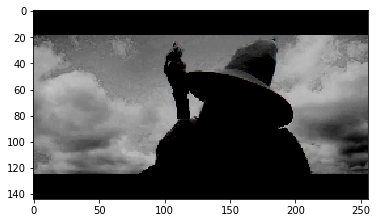

In [206]:
plt.imshow(imz)
plt.show()

In [ ]:
import numpy as np
import math

def psnr(img1, img2):
    mse = np.mean((img1-img2)**2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
print(psnr(Yhat_test[8,:,:,:],Y_test[8,:,:,:]))

In [ ]:
batch_size = 8
epochs = 4000
half_batch = int(batch_size / 2)

for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = Y_train[idx]
    #Previous frames
    dataimgs = X_train[idx]
    # Sample noise and generate a half batch of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = model_g.predict([noise, dataimgs])

    imgs = np.concatenate((dataimgs, imgs), 3);
    #gen_imgs = np.concatenate((dataimgs, gen_imgs), 3);

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = model_d.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = model_d.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Sample generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = model.train_on_batch([noise, np.concatenate((dataimgs, dataimgs))], np.ones((batch_size, 1)))

    # Plot the progress
    if epoch%100 == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

0 [D loss: 2.581730, acc.: 50.00%] [G loss: 0.004655]
100 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.000003]
200 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000010]


stopper = EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=0,
                              verbose=1, mode='auto')
model.fit(X_train, Y_train, 
          batch_size=8, epochs=10, callbacks=[stopper], verbose=1)

Yhat_test = model_d.predict(X_test)

Y_test.shape

import matplotlib.pyplot as plt
plt.imshow(Yhat_test[8,:,:,:])

batch_size = 8
epochs = 400
half_batch = int(batch_size / 2)

for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    # Sample noise and generate a half batch of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = model_g.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = model_d.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = model_d.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Sample generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = model.train_on_batch(noise, np.ones((batch_size, 1)))

    # Plot the progress
    if epoch%10 == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))